<h1>Improving Panacea's Patient-Trial Matching Capabilities Using Verification with Other LLMs</h1>

<h2>Reproduction of Results</h2>

<h3>Running Panacea</h3>
<p>Here we load and run Panacea on the first 100 samples in the test dataset (TREC2021) to reproduce and verify the results of the paper.</p>

<p>Note: I did not run the model on the full test dataset due to runtime limitations, and the plots found later on are based on the model outputs provided in the Panacea GitHub repo.</p>

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = 'linjc16/Panacea-7B-Chat'

# load Panacea
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto", attn_implementation='sdpa')
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
import json
from tqdm import tqdm
import os

save_dir = 'matching/results'
dataset = 'TREC2021'
sample = True

# load test dataset
with open(f'test.json', 'r') as f:
    inputs = json.load(f)

output_dict = {}

In [ ]:
from itertools import islice
from tqdm import tqdm

num_samples = 100

# run model on first 100 samples to verify results from the paper
for i, (key, value) in enumerate(tqdm(islice(inputs.items(), num_samples), total=num_samples)):
    prompt = value['input']
    messages = [{"role": "user", "content": prompt}]
    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        encodeds,
        max_new_tokens=512,
        do_sample=sample,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.batch_decode(generated_ids)[0]

    decoded = decoded.split('<|assistant|>')[-1].strip()

    output_dict[key] = {
        'output': decoded,
        'label': value['label']
    }

# save results to a json
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, 'panacea-7b.json'), 'w') as f:
    json.dump(output_dict, f, indent=4)

100%|██████████| 100/100 [3:15:18<00:00, 117.19s/it]


<h3>Function to Extract Prediction from Model Output</h3>

In [2]:
import re

def extract_prediction(output_str):
    match = re.search(r'Trial-level eligibility: (\d)\)', output_str)
    if match:
        pred = int(match.group(1))
        if pred in [0, 1, 2]:
            return pred
    # default to 0 if match not found to prioritize safety
    return 0

<h3>Evaluating Panacea</h3>
<p>We evaluate Panacea's performance on the first 200 samples of the test dataset.</p>

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

with open(f'matching/results/panacea-7b.json', 'r') as f:
    outputs = json.load(f)

labels = [entry["label"] for entry in outputs.values()]
preds = [extract_prediction(entry["output"]) for entry in outputs.values()]

print(labels)
print(preds)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, preds)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, preds)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, preds, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

[0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0]
[2, 1, 2, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2]
Balanced accuracy: 0.4508
Kappa: 0.1544
Precision: 0.5148
Recall: 0.4600
F1-score: 0.4721


<h2>Improvement Using Verification with Other LLMs</h2>

In [61]:
import json
from tqdm import tqdm
import os
import torch

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

# lists to keep track of models and eval metrics
models = []
baccs = []
kappas = []
precisions = []
recalls = []
f1s = []

<h3>Evaluating Single Models</h3>
<p>We calculate the metrics described in the paper (BACC, KAPPA, Precision, Recall, and F1) on several models that performed well (Panacea, Mistral, Zephyr, and LLaMA3) on the TREC2021 dataset.</p>

<p>The output files for each of these models, which contain results for all 7425 samples in the test dataset, are provided in the Panacea GitHub repo.</p>

<h4>Panacea</h4>

In [62]:
with open(f'panacea-7b-7425.json', 'r') as f:
    outputs = json.load(f)

labels = [entry["label"] for entry in outputs.values()]
preds_panacea = [extract_prediction(entry["output"]) for entry in outputs.values()]

print(labels)
print(preds_panacea)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, preds_panacea)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, preds_panacea)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, preds_panacea, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Panacea")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

[0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 

<h4>Mistral</h4>

In [63]:
import json
from tqdm import tqdm
import os
import torch

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

with open(f'mistral-7b-7425.json', 'r') as f:
    outputs = json.load(f)

labels = [entry["label"] for entry in outputs.values()]
preds_mistral = [extract_prediction(entry["output"]) for entry in outputs.values()]

print(labels)
print(preds_mistral)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, preds_mistral)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, preds_mistral)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, preds_mistral, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Mistral")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

[0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 

<h4>Zephyr</h4>

In [64]:
import json
from tqdm import tqdm
import os
import torch

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

with open(f'zephyr-7b-7425.json', 'r') as f:
    outputs = json.load(f)

labels = [entry["label"] for entry in outputs.values()]
preds_zephyr = [extract_prediction(entry["output"]) for entry in outputs.values()]

print(labels)
print(preds_zephyr)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, preds_zephyr)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, preds_zephyr)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, preds_zephyr, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Zephyr")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

[0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 

<h4>LLaMA3</h4>

In [65]:
import json
from tqdm import tqdm
import os
import torch

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

with open(f'llama3-8b-7425.json', 'r') as f:
    outputs = json.load(f)

labels = [entry["label"] for entry in outputs.values()]
preds_llama = [extract_prediction(entry["output"]) for entry in outputs.values()]

print(labels)
print(preds_llama)

# calculate eval metrics: BACC, KAPPA, and F1

balanced_accuracy = balanced_accuracy_score(labels, preds_llama)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, preds_llama)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, preds_llama, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("LLaMA3")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

[0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 

<h3>Evaluating Single Models on a Different Dataset</h3>
<p>We repeat the above process using the Cohort dataset, and we will use these results to inform the model combinations to avoid data leakage.</p>

In [66]:
import json
from tqdm import tqdm
import os
import torch

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

cohort_acc = []

# Panacea
with open(f'panacea-7b-cohort.json', 'r') as f:
    outputs = json.load(f)

labels_cohort = [entry["label"] for entry in outputs.values()]
preds_panacea_cohort = [extract_prediction(entry["output"]) for entry in outputs.values()]

print("Panacea:")

balanced_accuracy = balanced_accuracy_score(labels_cohort, preds_panacea_cohort)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

cohort_acc.append(balanced_accuracy.item())

# Mistral
with open(f'mistral-7b-cohort.json', 'r') as f:
    outputs = json.load(f)

labels_cohort = [entry["label"] for entry in outputs.values()]
preds_mistral_cohort = [extract_prediction(entry["output"]) for entry in outputs.values()]

print("Mistral:")

balanced_accuracy = balanced_accuracy_score(labels_cohort, preds_mistral_cohort)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

cohort_acc.append(balanced_accuracy.item())

# Zephyr
with open(f'zephyr-7b-cohort.json', 'r') as f:
    outputs = json.load(f)

labels_cohort = [entry["label"] for entry in outputs.values()]
preds_zephyr_cohort = [extract_prediction(entry["output"]) for entry in outputs.values()]

print("Zephyr:")

balanced_accuracy = balanced_accuracy_score(labels_cohort, preds_zephyr_cohort)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

cohort_acc.append(balanced_accuracy.item())

# LLaMA3
with open(f'llama3-8b-cohort.json', 'r') as f:
    outputs = json.load(f)

labels_cohort = [entry["label"] for entry in outputs.values()]
preds_llama_cohort = [extract_prediction(entry["output"]) for entry in outputs.values()]

print("LLaMA3:")

balanced_accuracy = balanced_accuracy_score(labels_cohort, preds_llama_cohort)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

cohort_acc.append(balanced_accuracy.item())

Panacea:
Balanced accuracy: 0.4696
Mistral:
Balanced accuracy: 0.3417
Zephyr:
Balanced accuracy: 0.3491
LLaMA3:
Balanced accuracy: 0.5065


<h3>Evaluating Model Combinations</h3>
<p>We test several strategies to combine the results of the various models in order to improve the overall accuracy and minimize LLM hallucinations.</p>

<h4>Majority Vote</h4>
<p>Count the votes for each output value. If there is a majority (3 out of 4 votes for the same value), return that value. Otherwise, default to Panacea output.</p>

In [67]:
from collections import Counter

final_preds = []
for p, m, z, l in zip(preds_panacea, preds_mistral, preds_zephyr, preds_llama):
    votes = [p, m, z, l]
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()

    if most_common[0][1] > 2:
        # if a majority exists (at least 3 votes for same value)
        final_preds.append(most_common[0][0])
    else:
        # if no majority, default to Panacea
        final_preds.append(p)

print(final_preds)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, final_preds)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, final_preds)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, final_preds, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Majority Vote")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

[2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 

<h4>Weighted Vote</h4>
<p>Assign weights to models based on their relative accuracy scores on the Cohort dataset (to avoid data leakage). Calculate the weighted votes for each output value. If there is a majority, return that value. Otherwise, default to Panacea output.</p>

In [68]:
import numpy as np

acc = np.array(cohort_acc)
p = 3

weights_array = acc**p
weights_array /= weights_array.sum()

model_names = ['panacea', 'mistral', 'zephyr', 'llama']

weights = dict(zip(model_names, weights_array))
weights = {k: float(v) for k, v in zip(model_names, weights_array)}

print(weights)

{'panacea': 0.32782808151766923, 'mistral': 0.126224669328121, 'zephyr': 0.13462392193408593, 'llama': 0.41132332722012377}


In [69]:
from collections import Counter

final_preds = []
for p, m, z, l in zip(preds_panacea, preds_mistral, preds_zephyr, preds_llama):
    # accumulate weighted votes
    vote_weights = Counter()
    vote_weights[p] += weights['panacea']
    vote_weights[m] += weights['mistral']
    vote_weights[z] += weights['zephyr']
    vote_weights[l] += weights['llama']

    # get class with highest weight
    most_common = vote_weights.most_common()

    # check for tie in weight
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        # default to Panacea
        final_preds.append(p)
    else:
        final_preds.append(most_common[0][0])

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, final_preds)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, final_preds)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, final_preds, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Weighted Vote")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

Balanced accuracy: 0.5235
Kappa: 0.3007
Precision: 0.6609
Recall: 0.6754
F1-score: 0.6574


<h4>Two-Model Average</h4>
<p>Because Panacea and LLaMA3 had much higher accuracy scores on the Cohort dataset, we use these two models for the two-model average. Calculate the average of the outputs of Panacea and LLaMA3. Return the floor of this value (we round down to prioritize safety).</p>

In [70]:
import math

final_preds = []
for p, l in zip(preds_panacea, preds_llama):
    sum = p * 0.5 + l * 0.5
    final_prediction = math.floor(sum)
    final_preds.append(final_prediction)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, final_preds)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, final_preds)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, final_preds, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Two-Model Average")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

Balanced accuracy: 0.5734
Kappa: 0.3427
Precision: 0.7331
Recall: 0.6419
F1-score: 0.6735


<h4>Per-Class Model Priority</h4>
<p>We first calculate the precision, recall, and F1 score across the models for each output value to determine if any models perform better on certain outputs. This is done on the Cohort dataset to avoid data leakage.</p>

In [71]:
from sklearn.metrics import classification_report
import pandas as pd

# function to get per-class accuracies
def get_class_report(labels, preds, model_name):
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    df = pd.DataFrame(report).T
    df['model'] = model_name
    return df

# reports for each model
report_panacea = get_class_report(labels_cohort, preds_panacea_cohort, "Panacea")
report_mistral = get_class_report(labels_cohort, preds_mistral_cohort, "Mistral")
report_zephyr = get_class_report(labels_cohort, preds_zephyr_cohort, "Zephyr")
report_llama = get_class_report(labels_cohort, preds_llama_cohort, "LLaMA")

all_reports = pd.concat([report_panacea, report_mistral, report_zephyr, report_llama])
per_class_accuracy = all_reports.loc[["0", "1", "2"]]

print(per_class_accuracy[['precision', 'recall', 'f1-score', 'model']])

   precision    recall  f1-score    model
0   0.827188  0.673661  0.742572  Panacea
0   0.729848  0.661722  0.694118  Mistral
0   0.723851  0.911360  0.806855   Zephyr
0   0.851816  0.644718  0.733937    LLaMA
1   0.258206  0.172263  0.206655  Panacea
1   0.193986  0.291971  0.233100  Mistral
1   0.220408  0.078832  0.116129   Zephyr
1   0.257642  0.430657  0.322404    LLaMA
2   0.203959  0.562945  0.299431  Panacea
2   0.090090  0.071259  0.079576  Mistral
2   0.165517  0.057007  0.084806   Zephyr
2   0.295419  0.444181  0.354839    LLaMA


<p>The results from above show that LLaMA has a significantly higher precision and F1 than Panacea for an output of 2. Thus, if LLaMA predicts 2 we return LLaMA's output; otherwise we default to Panacea's output.</p>

In [72]:
final_preds = []

for p, m, z, l in zip(preds_panacea, preds_mistral, preds_zephyr, preds_llama):
    if l == 2:
        final_preds.append(l)
    else:
        final_preds.append(p)

# calculate eval metrics

balanced_accuracy = balanced_accuracy_score(labels, final_preds)
print(f"Balanced accuracy: {balanced_accuracy:.4f}")

kappa = cohen_kappa_score(labels, final_preds)
print(f"Kappa: {kappa:.4f}")

report = classification_report(labels, final_preds, output_dict=True, zero_division=0)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

# add model name and eval metrics to corresponding lists
models.append("Per-Class Model Priority")
baccs.append(balanced_accuracy.item())
kappas.append(kappa.item())
precisions.append(report['weighted avg']['precision'])
recalls.append(report['weighted avg']['recall'])
f1s.append(report['weighted avg']['f1-score'])

Balanced accuracy: 0.5437
Kappa: 0.2885
Precision: 0.7126
Recall: 0.5869
F1-score: 0.6081


<h3>Plotting Results</h3>

<h4>Legend</h4>

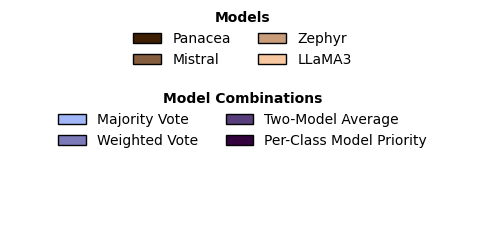

In [78]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

colors = ['#3E1F03', '#845E3E', '#C99D79', '#F7C7A0', '#A1B6F7', '#7C7AB9', '#583F7B', '#33033D']

# separate into models vs model combos
models1 = models[:4]
models2 = models[4:8]
colors1 = colors[:4]
colors2 = colors[4:8]

model_handles = [Patch(facecolor=color, edgecolor='black', label=label)
                 for color, label in zip(colors1, models1)]

combo_handles = [Patch(facecolor=color, edgecolor='black', label=label)
                 for color, label in zip(colors2, models2)]

# plot figure
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')

# add first legend
legend1 = ax.legend(handles=model_handles, title='Models',
                    loc='upper center', bbox_to_anchor=(0.5, 1.05),
                    ncol=2, frameon=False)
ax.add_artist(legend1)
legend1.get_title().set_fontweight('bold')

# add second legend
legend2 = ax.legend(handles=combo_handles, title='Model Combinations',
                    loc='upper center', bbox_to_anchor=(0.5, 0.7),
                    ncol=2, frameon=False)
legend2.get_title().set_fontweight('bold')

plt.show()

<h4>Balanced Accuracy</h4>

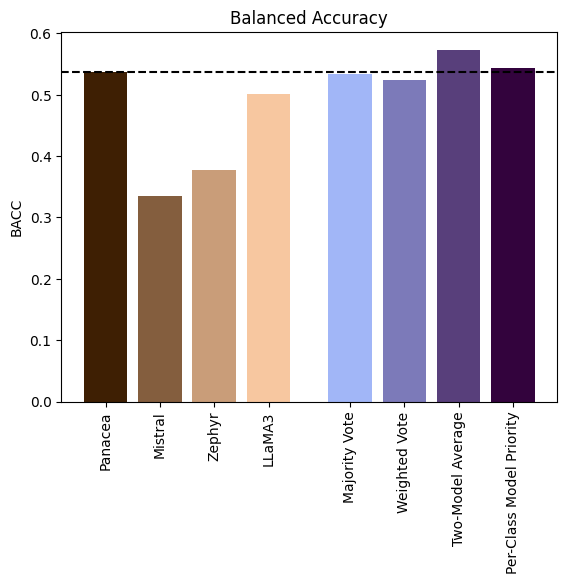

In [79]:
x_positions = list(range(len(models)))
gap_index = 4
for i in range(gap_index, len(x_positions)):
    x_positions[i] += 0.5

plt.bar(x_positions, baccs, color=colors)
plt.axhline(y=baccs[0], linestyle='dashed', color='black')
plt.xticks(x_positions, models, rotation=90)
plt.ylabel('BACC')
plt.title('Balanced Accuracy')
plt.show()

<h4>Cohen's KAPPA</h4>

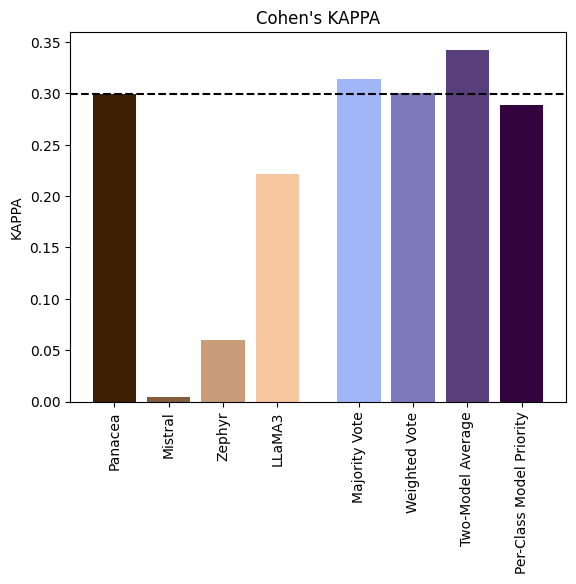

In [80]:
x_positions = list(range(len(models)))
gap_index = 4
for i in range(gap_index, len(x_positions)):
    x_positions[i] += 0.5

plt.bar(x_positions, kappas, color=colors)
plt.axhline(y=kappas[0], linestyle='dashed', color='black')
plt.xticks(x_positions, models, rotation=90)
plt.ylabel('KAPPA')
plt.title('Cohen\'s KAPPA')
plt.show()

<h4>Precision</h4>

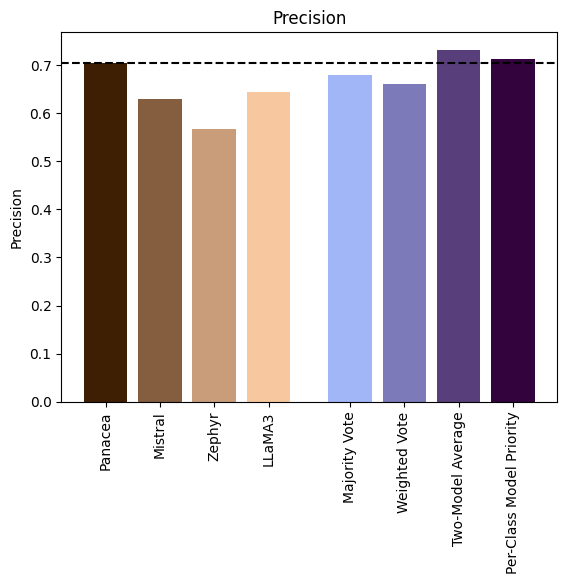

In [81]:
x_positions = list(range(len(models)))
gap_index = 4
for i in range(gap_index, len(x_positions)):
    x_positions[i] += 0.5

plt.bar(x_positions, precisions, color=colors)
plt.axhline(y=precisions[0], linestyle='dashed', color='black')
plt.xticks(x_positions, models, rotation=90)
plt.ylabel('Precision')
plt.title('Precision')
plt.show()

<h4>Recall</h4>

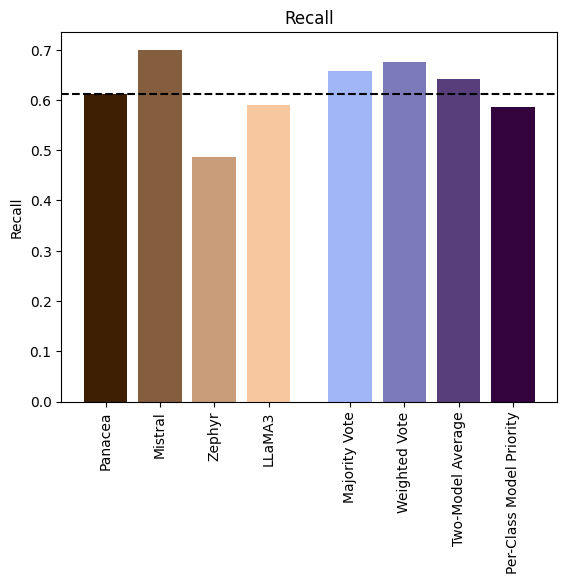

In [82]:
x_positions = list(range(len(models)))
gap_index = 4
for i in range(gap_index, len(x_positions)):
    x_positions[i] += 0.5

plt.bar(x_positions, recalls, color=colors)
plt.axhline(y=recalls[0], linestyle='dashed', color='black')
plt.xticks(x_positions, models, rotation=90)
plt.ylabel('Recall')
plt.title('Recall')
plt.show()

<h4>F1 Score</h4>

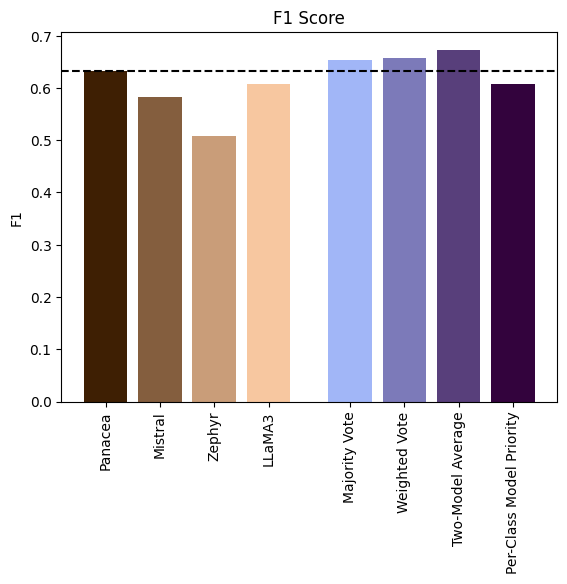

In [83]:
x_positions = list(range(len(models)))
gap_index = 4
for i in range(gap_index, len(x_positions)):
    x_positions[i] += 0.5

plt.bar(x_positions, f1s, color=colors)
plt.axhline(y=f1s[0], linestyle='dashed', color='black')
plt.xticks(x_positions, models, rotation=90)
plt.ylabel('F1')
plt.title('F1 Score')
plt.show()